In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow version 2.2.0
Num GPUs Available:  1


In [2]:
# creating 'data flow' for training data from data directory using ImageDataGenerator class
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMAGE_SIZE = [256, 256]

# we will use data augmentation for train dataset
train_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=15, width_shift_range=0.15, 
                                          height_shift_range=0.15,zoom_range=.15, horizontal_flip=True)

train_data_flow = train_data_generator.flow_from_directory(directory = 'data/train', 
                                                           classes=['non_georges', 'georges'], target_size = IMAGE_SIZE,
                                                           color_mode="rgb",batch_size = BATCH_SIZE,
                                                           class_mode='binary',shuffle = True,seed=42)

Using TensorFlow backend.


Found 4232 images belonging to 2 classes.


In [3]:
# creating 'data flow' for validation data from data directory using ImageDataGenerator class

valid_data_generator = ImageDataGenerator(rescale=1./255)

valid_data_flow = valid_data_generator.flow_from_directory(directory = 'data/valid', 
                                                           classes=['non_georges', 'georges'], target_size = IMAGE_SIZE,
                                                           color_mode="rgb",batch_size = BATCH_SIZE,
                                                           class_mode='binary',shuffle = True,seed=42)

Found 1810 images belonging to 2 classes.


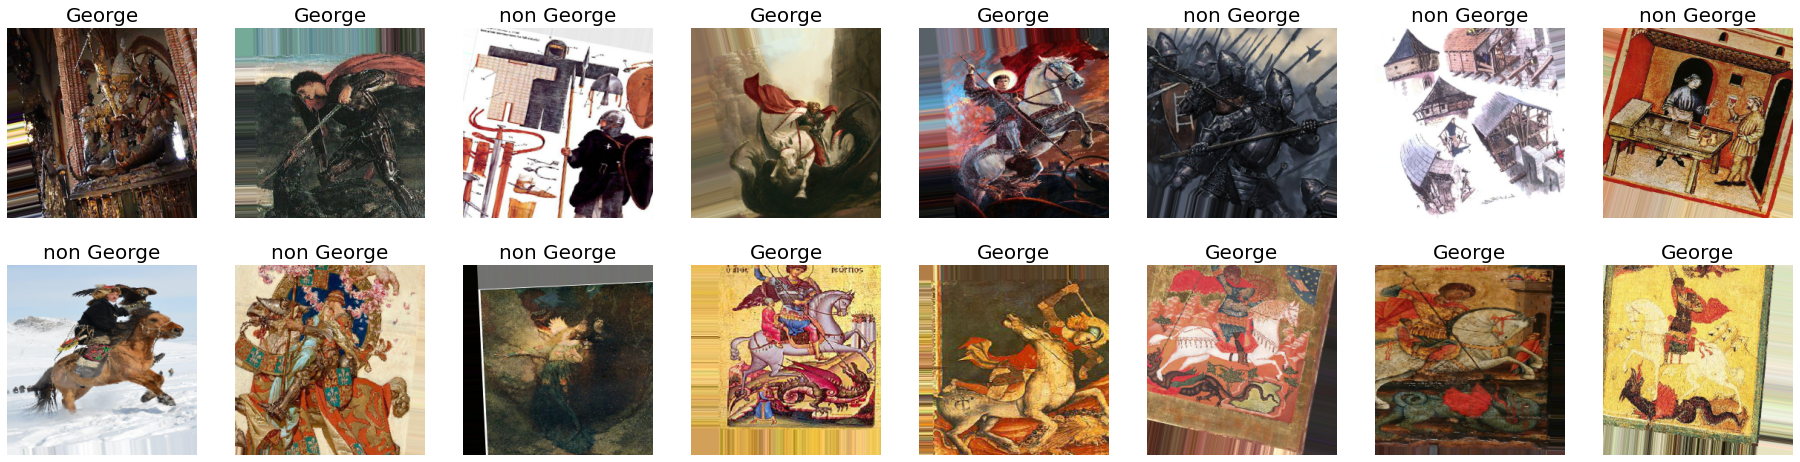

In [5]:
# plot images from train data flow

def plot_multiple_images(images_batch, n = BATCH_SIZE):
    n_cols = n // 2
    n_rows = 2
    plt.figure(figsize=(4*n_cols, 4*n_rows))
    images, labels = images_batch
    
    for i in range(n):
        index = i 
        image = tf.expand_dims(images[index], 0).numpy()
        image = np.squeeze(image, axis=0)
        label = labels[index]
        if label == 0:
            title = 'non George'
        else:
            title = 'George'
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(title, fontsize=int(20), color='black')
        plt.imshow(image)
        plt.axis("off")
        
plot_multiple_images(next(train_data_flow))

Learning rate schedule: 1e-05 to 5e-05 to 1.11e-05


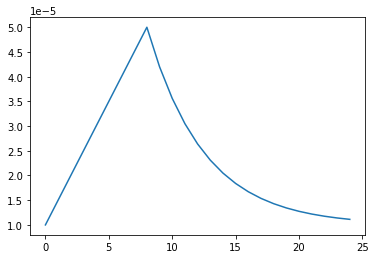

In [11]:
# create learning rate schedule

EPOCHS = 25

LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 8
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
        
@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [8]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [12]:
# We will use pretrained Xception network as basis for our classifier.
# Later, I tested the ResNet50 and InceptionV3 architectures, the Xception network showed the best result.

pretrained_model_1 = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model_1.trainable = True 

model_1 = tf.keras.Sequential([pretrained_model_1, 
                               tf.keras.layers.GlobalAveragePooling2D(),
                               tf.keras.layers.Dense(1, activation='sigmoid')])

model_1.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
earlystoping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, 
                                                         monitor='val_accuracy', mode='auto')

In [13]:
# Train modified Xception model

EPOCHS = 25
STEPS_PER_EPOCH = 4232 // BATCH_SIZE

history_1 = model_1.fit(train_data_flow, shuffle=True, steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS,validation_data=valid_data_flow, 
                        callbacks=[lr_callback, earlystoping_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-05, shape=(), dtype=float32).
Epoch 1/25
264/264 [==============================] - 134s 508ms/step - loss: 0.5640 - accuracy: 0.7332 - val_loss: 0.4161 - val_accuracy: 0.8271 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(1.5e-05, shape=(), dtype=float32).
Epoch 2/25
264/264 [==============================] - 132s 499ms/step - loss: 0.3723 - accuracy: 0.8472 - val_loss: 0.2883 - val_accuracy: 0.8829 - lr: 1.5000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(2e-05, shape=(), dtype=float32).
Epoch 3/25
264/264 [==============================] - 130s 492ms/step - loss: 0.2793 - accuracy: 0.8857 - val_loss: 0.2263 - val_accuracy: 0.9099 - lr: 2.0000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(2.5e-05, shape=(), dtype=float32).
Epoch 4/25
264/264 [==============================] - 135s 510ms/step - loss: 0.2178 - 

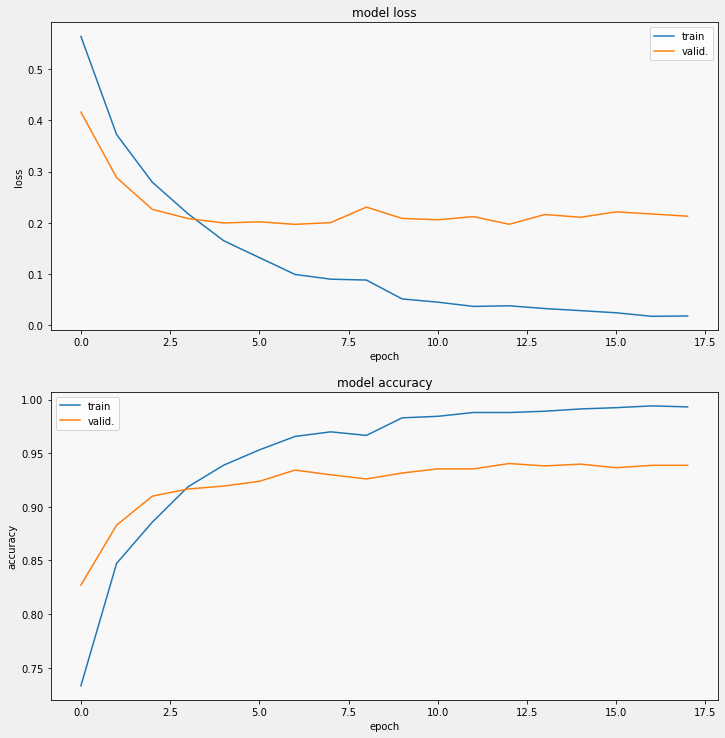

In [14]:
# Display training curves for modified Xception model

display_training_curves(history_1.history['loss'], history_1.history['val_loss'], 'loss', 211)
display_training_curves(history_1.history['accuracy'], history_1.history['val_accuracy'], 'accuracy', 212)

In [15]:
# Evaluate trained classifier

Xception_loss, Xception_accuracy = model_1.evaluate(valid_data_flow)

114/114 [==============================] - 15s 135ms/step - loss: 0.1972 - accuracy: 0.9403


In [18]:
print('model accuracy: '+ str(Xception_accuracy))

model accuracy: 0.9403315186500549


In [25]:
# make predictions

valid_data_flow_2 = valid_data_generator.flow_from_directory(directory = 'data/valid', 
                                                           classes=['non_georges', 'georges'], target_size = IMAGE_SIZE,
                                                           color_mode="rgb",batch_size = 1810,
                                                           class_mode='binary',shuffle = True,seed=42)


images, valid_labels = next(valid_data_flow_2) 
valid_pred = model_1.predict(images)

Found 1810 images belonging to 2 classes.


In [27]:
valid_predictions = np.around(valid_pred)

In [30]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_labels, valid_predictions)
cm

array([[959,  47],
       [ 61, 743]])

In [31]:
# Accuracy, precision and recall scores for validation set

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

accuracy = accuracy_score(valid_labels, valid_predictions)
precision = precision_score(valid_labels, valid_predictions)
recall = recall_score(valid_labels, valid_predictions)

print("Accuracy score: " + str(accuracy))
print("Precision score: " + str(precision))
print("Recall score: " + str(recall))

Accuracy score: 0.9403314917127071
Precision score: 0.9405063291139241
Recall score: 0.9241293532338308
